In [1]:
%pwd

'c:\\Users\\kgn\\OneDrive - PowerSchool\\PowerSchool\\Release Script\\Python\\Data Scientist\\LLMScratch\\notebook'

In [2]:
import os
os.chdir("../")
%pwd

'c:\\Users\\kgn\\OneDrive - PowerSchool\\PowerSchool\\Release Script\\Python\\Data Scientist\\LLMScratch'

In [3]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.3
numpy version: 1.26.4
tiktoken version: 0.9.0
torch version: 2.7.1


In [44]:
import torch
from modules.supplementary_pretraining import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 32, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [28]:
import tiktoken
from modules.supplementary_pretraining import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [40]:
# start_context = "Every effort moves you"
start_context ="Snippet is"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Snippet isaucas creditedads legality tune Plus385 Ment chiefly unveil


In [30]:
with open("notebook/easy_edit.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

In [31]:
# First 100 characters
print(text_data[:99])

[New in 20.6.3.0] To support a new and more robust approach to snippets which will culminate in a m


In [32]:
# Last 100 characters
print(text_data[-99:])

g “Security” from the “Administration” menu, and then “Set Admin Options” from the “More” dropdown.


In [41]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 2309
Tokens: 587


In [45]:
from modules.supplementary_pretraining import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
# print(split_idx)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
# print(f"Train Data:\n{train_data}")
# print(f"Validation Data:\n{val_data}")

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [46]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 32]) torch.Size([2, 32])

Validation loader:
torch.Size([1, 32]) torch.Size([1, 32])


In [47]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 512
Validation tokens: 32
All tokens: 544


In [51]:
from modules.supplementary_pretraining import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

cpu
Training loss: 4.723143428564072
Validation loss: 9.728282928466797


In [49]:
from modules.supplementary_pretraining import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [52]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Snippet is", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.050, Val loss 10.640
Ep 1 (Step 000005): Train loss 6.434, Val loss 9.928
Snippet is <p-21">contents</p-21">contents</p-21">contents tag will be inserted above the target tag the target tag the target tag the target tag the target tag the target tag the target tag the target tag
Ep 2 (Step 000010): Train loss 3.626, Val loss 9.227
Ep 2 (Step 000015): Train loss 1.889, Val loss 8.666
Snippet is <p snippet-id="p-21">contents</p snippet content you specify the target tag is <p snippet content you specify the target tag is <p snippet content you specify the target tag is <p snippet content as a new p
Ep 3 (Step 000020): Train loss 1.525, Val loss 8.689
Snippet is <p snippet-id="p snippet-id="p snippet-id="p snippet-id="p snippet-21">contents</p snippet-id="p snippet-id="p snippet-id="p snippet-id="p
Ep 4 (Step 000025): Train loss 0.775, Val loss 8.110
Ep 4 (Step 000030): Train loss 0.428, Val loss 7.894
Snippet is <p-21">contents</p>. 5) Insert Below Outsid

In [53]:
torch.save(model.state_dict(), "model/model.pth")

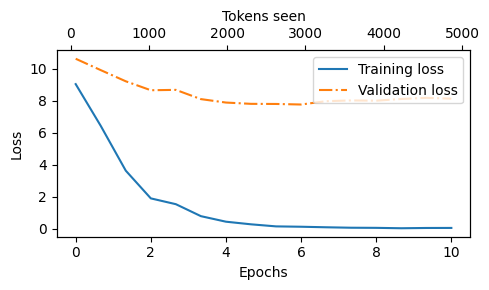

In [54]:
from modules.supplementary_pretraining import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [58]:
# start_context = "Snippet is"

start_context = "Inserts the new snippet"
tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids=token_ids,tokenizer=tokenizer))

Output text:
 Inserts the new snippet-id="p-21">contents</


In [59]:
import torch

# Imports from a local file
from modules.supplementary_pretraining import GPTModel


model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model/model.pth", map_location=device))
model.eval();